# 2.6 Linear State Space Models

## The Linear State Space Model

* $x_t$：$t=0,1,2,\dots$期におけるstate ($n \times 1$)
* $w_t \sim N(0,I)$：iidのrandom vector ($m \times 1$)
* $y_t$：$t=0,1,2,\dots$期のobservation ($k \times 1$)
* $A$：transition matrix ($n \times n$)
* $C$：volatility matrix ($n \times m$)
* $G$：output matrix ($k \times n$)

$$
\begin{align}
x_{t+1} &= A x_t + C w_{t+1}\\
y_t &= G x_t\\
x_0 &\sim N(\mu_0, \Sigma_0)
\end{align}
$$

* $A$，$C$，$G$を所与として$x_0$と$w_1,w_2,\dots$が決まれば$\{x_t\}$と$\{y_t\}$が決まる
* $x_0$と$w_1,w_2,\dots$が決まらなくても$\{x_t\}$と$\{y_t\}$の分布は決まる

## Martingale difference shocks

*Martingale difference sequence*：過去の情報を条件とした期待値が0になる列

* $\{x_t\}$を条件として$\{w_t\}$がMartingale difference sequenceである：
$$
\mathbb E[w_{t+1} \mid x_t,x_{t-1},\dots]=0
$$
これは$\{w_t\}$が$w_{t+1} \sim N(0,I)$となるiidであるという条件より緩い

## Code

本節では`quantecon`パッケージに含まれる`lss.py`を多用するので先にその内容を確認しておく．

import部分

```python

from textwrap import dedent
import numpy as np
from numpy.random import multivariate_normal
from scipy.linalg import solve

#-Check if Numba is Available-#
from .util import numba_installed, jit

```

`numpy`と`scipy`については毎度おなじみ．
`dedent`は文字列の先頭のインデントを取り除く

パラメータの行列`A`と初期値`x0`，ショック`v`，期間の長さ`ts_length`を与えると
$$
x_{t+1} = A x_t + v_t,\ \text{given } x_0 = x0
$$
をシミュレートする関数．$\{x_t\}^{\text{ts_length}}_{t=0}$を返す．


```python

def simulate_linear_model(A, x0, v, ts_length):
    A = np.asarray(A)
    n = A.shape[0]
    x = np.empty((n, ts_length))
    x[:, 0] = x0
    for t in range(ts_length-1):
        # x[:, t+1] = A.dot(x[:, t]) + v[:, t]
        for i in range(n):
            x[i, t+1] = v[i, t]                   #Shock
            for j in range(n):
                x[i, t+1] += A[i, j] * x[j, t]   #Dot Product
    return x

if numba_installed:
    simulate_linear_model = jit(simulate_linear_model)
```
numbaがインストールされていればnumbaを使って高速化

```python

class LinearStateSpace(object):
    
    def __init__(self, A, C, G, H=None, mu_0=None, Sigma_0=None):
        self.A, self.G, self.C = list(map(self.convert, (A, G, C)))
        #-Check Input Shapes-#
        ni,nj = self.A.shape
        if ni != nj:
            raise ValueError("Matrix A (shape: %s) needs to be square" % (self.A.shape))
        if ni != self.C.shape[0]:
            raise ValueError("Matrix C (shape: %s) does not have compatible dimensions with A. It should be shape: %s" % (self.C.shape, (ni,1)))
        self.m = self.C.shape[1]
        self.k, self.n = self.G.shape
        if self.n != ni:
            raise ValueError("Matrix G (shape: %s) does not have compatible dimensions with A (%s)"%(self.G.shape, self.A.shape))
        if H is None:
            self.H = None
            self.l = None
        else:
            self.H = self.convert(H)
            self.l = self.H.shape[1]
        if mu_0 is None:
            self.mu_0 = np.zeros((self.n, 1))
        else:
            self.mu_0 = self.convert(mu_0)
            self.mu_0.shape = self.n, 1  
        if Sigma_0 is None:
            self.Sigma_0 = np.zeros((self.n, self.n))
        else:
            self.Sigma_0 = self.convert(Sigma_0)

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        m = """\
        Linear Gaussian state space model:
          - dimension of state space          : {n}
          - number of innovations             : {m}
          - dimension of observation equation : {k}
        """
        return dedent(m.format(n=self.n, k=self.k, m=self.m))
```
行列の形に制約（正方行列であるかどうか等）があるのでインスタンスを作る時点で制約を満たすか確認している．

ところどころにある`convert`はこのあと定義

```python
    def convert(self, x):
        """
        Convert array_like objects (lists of lists, floats, etc.) into
        well formed 2D NumPy arrays

        """
        return np.atleast_2d(np.asarray(x, dtype='float32'))
```

やっていることはメソッド`atleast_2d`をつかって配列の次元を二次以上に変換する作業

配列の次元：何重のリストになっているか
次元自体は`ndim`で確認可能

In [17]:
# スカラー
A = 1
A = np.array(A)
A.ndim

0

In [18]:
# ベクトル
A = [1,2,3]
A = np.array(A)
A.ndim

1

In [19]:
# 行列
A = [[1,2],[3,4]]
A = np.array(A)
A.ndim

2

配列の次元は転置を考えるときに重要になる．
行列であれば，`numpy`の`T`を使えば意図した通りに転置を計算できる

In [20]:
A = [[1,2],[3,4]]
A = np.array(A)
A.T

array([[1, 3],
       [2, 4]])

一方ベクトルだと上手くいかない．行ベクトルの転置は列ベクトルになって欲しいが…

In [21]:
A = [1,2,3]
A = np.array(A)
A.T

array([1, 2, 3])

この問題に対処するために`atleast_2d`を使う

In [23]:
A = [1,2,3]
A = np.array(A)
A = np.atleast_2d(A)
A.T

array([[1],
       [2],
       [3]])

In [51]:
import numpy

A = 1
A = np.atleast_1d(A)
A

array([1])

In [8]:
import numpy as np

def convert(x):
    """
    Convert array_like objects (lists of lists, floats, etc.) into
    well formed 2D NumPy arrays
    
    """
    return np.atleast_2d(np.asarray(x, dtype='float32'))

```python
    def simulate(self, ts_length=100):
        """
        Simulate a time series of length ts_length, first drawing

            x_0 ~ N(mu_0, Sigma_0)

        Parameters
        ----------

        ts_length : scalar(int), optional(default=100)
            The length of the simulation

        Returns
        -------
        x : array_like(float)
            An n x ts_length array, where the t-th column is x_t
        y : array_like(float)
            A k x ts_length array, where the t-th column is y_t

        """
        x0 = multivariate_normal(self.mu_0.flatten(), self.Sigma_0)
        w = np.random.randn(self.m, ts_length-1)
        v = self.C.dot(w) # Multiply each w_t by C to get v_t = C w_t
        # == simulate time series == #
        x = simulate_linear_model(self.A, x0, v, ts_length)
        
        if self.H is not None:
            v = np.random.randn(self.l, ts_length)
            y = self.G.dot(x) + self.H.dot(v)
        else:
            y = self.G.dot(x)

        return x, y
```

インスタンスが持っているパラメータと指定した期間から状態の列と実現値の列を返す．

初期の状態は正規分布$N(\mu_0, \Sigma_0)$にしたがって選ばれる

```python

    def replicate(self, T=10, num_reps=100):
        """
        Simulate num_reps observations of x_T and y_T given
        x_0 ~ N(mu_0, Sigma_0).

        Parameters
        ----------
        T : scalar(int), optional(default=10)
            The period that we want to replicate values for
        num_reps : scalar(int), optional(default=100)
            The number of replications that we want

        Returns
        -------
        x : array_like(float)
            An n x num_reps array, where the j-th column is the j_th
            observation of x_T

        y : array_like(float)
            A k x num_reps array, where the j-th column is the j_th
            observation of y_T

        """
        x = np.empty((self.n, num_reps))
        for j in range(num_reps):
            x_T, _ = self.simulate(ts_length=T+1)
            x[:, j] = x_T[:, -1]
        if self.H is not None:
            v = np.random.randn(self.l, num_reps)
            y = self.G.dot(x) + self.H.dot(v)
        else:
            y = self.G.dot(x)

        return x, y

```

`num_reps`の数だけ`T`期間のシミュレーションを行い，それぞれのサンプルの$x_T$と$y_T$の値を返す

```python

    def moment_sequence(self):
        """
        Create a generator to calculate the population mean and
        variance-convariance matrix for both x_t and y_t, starting at
        the initial condition (self.mu_0, self.Sigma_0).  Each iteration
        produces a 4-tuple of items (mu_x, mu_y, Sigma_x, Sigma_y) for
        the next period.

        Yields
        ------
        mu_x : array_like(float)
            An n x 1 array representing the population mean of x_t
        mu_y : array_like(float)
            A  k x 1 array representing the population mean of y_t
        Sigma_x : array_like(float)
            An n x n array representing the variance-covariance matrix
            of x_t
        Sigma_y : array_like(float)
            A k x k array representing the variance-covariance matrix
            of y_t

        """
        # == Simplify names == #
        A, C, G, H = self.A, self.C, self.G, self.H
        # == Initial moments == #
        mu_x, Sigma_x = self.mu_0, self.Sigma_0

        while 1:
            mu_y = G.dot(mu_x)
            if H is None:
                Sigma_y = G.dot(Sigma_x).dot(G.T)
            else:
                Sigma_y = G.dot(Sigma_x).dot(G.T) + H.dot(H.T)

            yield mu_x, mu_y, Sigma_x, Sigma_y

            # == Update moments of x == #
            mu_x = A.dot(mu_x)
            Sigma_x = A.dot(Sigma_x).dot(A.T) + C.dot(C.T)
```

各時点のモーメントを返すgenerator

一時点の`mu_x`, `mu_y`, `Sigma_x`, `Sigma_y`がまとめて返ってくる



```python
def stationary_distributions(self, max_iter=200, tol=1e-5):
        """
        Compute the moments of the stationary distributions of x_t and
        y_t if possible.  Computation is by iteration, starting from the
        initial conditions self.mu_0 and self.Sigma_0

        Parameters
        ----------
        max_iter : scalar(int), optional(default=200)
            The maximum number of iterations allowed
        tol : scalar(float), optional(default=1e-5)
            The tolerance level that one wishes to achieve

        Returns
        -------
        mu_x_star : array_like(float)
            An n x 1 array representing the stationary mean of x_t
        mu_y_star : array_like(float)
            An k x 1 array representing the stationary mean of y_t
        Sigma_x_star : array_like(float)
            An n x n array representing the stationary var-cov matrix
            of x_t
        Sigma_y_star : array_like(float)
            An k x k array representing the stationary var-cov matrix
            of y_t

        """
        # == Initialize iteration == #
        m = self.moment_sequence()
        mu_x, mu_y, Sigma_x, Sigma_y = next(m)
        i = 0
        error = tol + 1

        # == Loop until convergence or failure == #
        while error > tol:

            if i > max_iter:
                fail_message = 'Convergence failed after {} iterations'
                raise ValueError(fail_message.format(max_iter))

            else:
                i += 1
                mu_x1, mu_y1, Sigma_x1, Sigma_y1 = next(m)
                error_mu = np.max(np.abs(mu_x1 - mu_x))
                error_Sigma = np.max(np.abs(Sigma_x1 - Sigma_x))
                error = max(error_mu, error_Sigma)
                mu_x, Sigma_x = mu_x1, Sigma_x1

        # == Prepare return values == #
        mu_x_star, Sigma_x_star = mu_x, Sigma_x
        mu_y_star, Sigma_y_star = mu_y1, Sigma_y1

        return mu_x_star, mu_y_star, Sigma_x_star, Sigma_y_star
```
$x$，$y$の定常分布の平均と分散共分散行列を返す
収束の基準は`tol`，距離概念は最大値距離

```python
    def geometric_sums(self, beta, x_t):
        """
        Forecast the geometric sums

            S_x := E [sum_{j=0}^{\infty} beta^j x_{t+j} | x_t ]

            S_y := E [sum_{j=0}^{\infty} beta^j y_{t+j} | x_t ]

        Parameters
        ----------
        beta : scalar(float)
            Discount factor, in [0, 1)

        beta : array_like(float)
            The term x_t for conditioning

        Returns
        -------
        S_x : array_like(float)
            Geometric sum as defined above

        S_y : array_like(float)
            Geometric sum as defined above

        """
        I = np.identity(self.n)
        S_x = solve(I - beta * self.A, x_t)
        S_y = self.G.dot(S_x)

        return S_x, S_y
```

無限級数（の理論値）を求める．

### 例1: Second-order difference equation

$$
y_{t+1}=\phi_0 + \phi_1 y_t + \phi_2 y_{t-1}\ \text{s.t.}\ y_0, y_{-1}\ \text{given}
$$
をlinear state space modelで記述すると，
$$
\begin{align}
&x_t = \left[
\begin{matrix}
1 \\ y_t \\ y_{t-1}
\end{matrix}
\right]
&A =\left[
\begin{matrix}
1 & 0 & 0 \\ \phi_0 & \phi_1 & \phi_2 \\ 0 & 1 & 0
\end{matrix}
\right]\\
&C = \left[
\begin{matrix}
0 \\ 0 \\ 0
\end{matrix}
\right]
&G=\left[
\begin{matrix}
0 & 1 & 0
\end{matrix}
\right]
\end{align}
$$

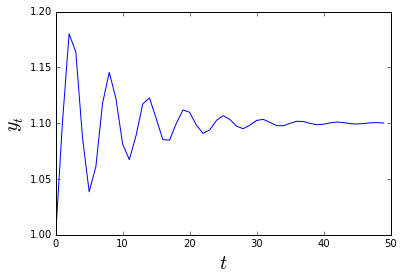

In [54]:
%matplotlib inline

from quantecon import LinearStateSpace
import numpy as np
import matplotlib.pyplot as plt

n = 50
phi0, phi1, phi2 = 1.1, 0.8, -0.8
y0, yminus1 = 1, 1

phi0, phi1, phi2 = 1.1, 0.8, -0.8

A = [[1, 0, 0],
     [phi0, phi1, phi2],
     [0, 1, 0]]
C = [[0], [0], [0]]
G = [0, 1, 0]
mu_0 = [1,1,1]


ar = LinearStateSpace(A, C, G, H=None, mu_0=mu_0, Sigma_0=None)
x, y = ar.simulate(50)

y = y.flatten()


fig, ax = plt.subplots()
ax.plot(y, 'b-')
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$y_t$', fontsize=20)
plt.show()

In [52]:
import numpy

A = np.array([[1,2,3],[4,5,6],[7,8,9]])
A = A.flatten()
A

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### Univariate Autoregressive Processes

$$
y_{t+1} = \phi_1 y_t+\phi_2 y_{t-1} + \phi_3 y_{t-2}+\phi_4 y_{t-3} + \sigma w_{t+1}
$$
をlinear state space modelで表現する
（$\{w_t\}$は標準正規分布に従う）


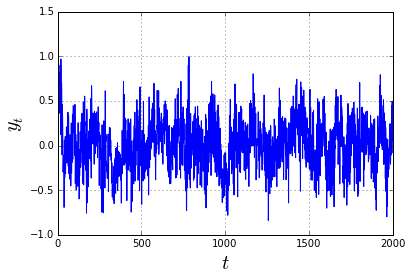

In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

phi1, phi2, phi3, phi4 = 0.5, -0.2, 0, 0.5
sigma = 0.2
y0, yminus1, yminus2, yminus3 = 1, 1, 1, 1
n = 2000

A = np.array([[phi1, phi2, phi3, phi4],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])

C = np.array([[sigma],
              [0],
              [0],
              [0]])

G = np.array([1, 0, 0, 0])

mu_0 = np.array([1,1,1,1])

ar = LinearStateSpace(A, C, G, H=None, mu_0=mu_0)
x, y = ar.simulate(n)
y = y.flatten()


fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlim(0,n)
ax.grid()
ax.set_xlabel(r'$t$', size = 20)
ax.set_ylabel(r'$y_t$', size = 20)
plt.show()

### Vector Autoregressions

* $y_t$：$k \times 1$ベクトル
* $\phi_j$：$k \times k$行列
* $w_t$：$k \times 1$ベクトル

とすると，
$$
y_{t+1}=\phi_1 y_t + \phi_2 y_{t-1} + \phi_3 y_{t-2} + \phi_4 y_{t-3} + \sigma w_t
$$
はvector autregressionになる．

これをlinear state space modelで表現すると，
$$
x_t=\left[ 
\begin{matrix}
y_t\\ y_{t-1}\\ y_{t-2} \\ y_{t-3}
\end{matrix}
\right],\ 
A=\left[\begin{matrix}
\phi_1 & \phi_2 & \phi_3 & \phi_4\\
I & 0 & 0 & 0\\
0 & I & 0 & 0\\
0 & 0 & I & 0
\end{matrix} \right],\ 
C=\left[\begin{matrix}
\sigma \\ 0 \\ 0 \\ 0
\end{matrix}\right],\ 
G= \left[ \begin{matrix}
I & 0 & 0 & 0
\end{matrix} \right]
$$
$I$は$k \times k$の単位行列，$\sigma$は$k \times k$行列

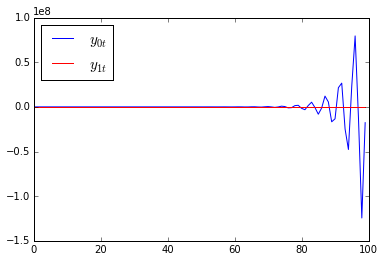

In [8]:
%matplotlib inline
from quantecon import LinearStateSpace
import numpy as np
import matplotlib.pyplot as plt

k = 2

# phi_1 = np.array([[1.3,0.5],[0.6,0.8]])
# phi_2 = np.array([[0.1,0.3],[0.7,0.4]])
# phi_3 = np.array([[0.5,0.6],[0.2,0.3]])
# phi_4 = np.array([[0.9,0.2],[0.5,0.8]])

# sigma = np.array([[0.3,0.6],[0.2,0.4]])

phi_1 = np.array([[np.random.uniform(-1,1) for i in range(k)] for j in range(k)])
phi_2 = np.array([[np.random.uniform(-1,1) for i in range(k)] for j in range(k)])
phi_3 = np.array([[np.random.uniform(-1,1) for i in range(k)] for j in range(k)])
phi_4 = np.array([[np.random.uniform(-1,1) for i in range(k)] for j in range(k)])

sigma = np.array([[np.random.uniform(-1,1) for i in range(k)] for j in range(k)])

I = np.identity(k)
Z = np.zeros((k,k))

A = np.array([[phi_1, phi_2, phi_3, phi_4],
              [I, Z, Z, Z],
              [Z, I, Z, Z],
              [Z, Z, I, Z]])

C = np.array([sigma, Z, Z, Z])

G = np.array([I, Z, Z, Z])

mu_0 = np.ones((4,k))

A.shape = (k*4,k*4)
C.shape = (k*4, k)
G.shape = (k, k*4)

ar = LinearStateSpace(A, C, G, H=None, mu_0=mu_0)
x, y = ar.simulate(100)

y_0 = y[0].flatten()
y_1 = y[1].flatten()


fig, ax = plt.subplots()
ax.plot(y_0, 'b-', label=r'$y_{0t}$')
ax.plot(y_1, 'r-', label=r'$y_{1t}$')
plt.legend(loc='best', fontsize = 15)
plt.show()

In [9]:
import numpy

conv = np.abs(np.linalg.eigvals(A)) < 1
print(conv)
all(conv) == 1

[False False False  True  True  True  True  True]


False

### Seasonals

四期間前との相関があるケース
* deterministic seasonal $y_t=y_{t-4}$
* indeterministic seasonal $y_t=\phi_4 y_{t-4}+w_t$

$$
A=\left[ \begin{matrix}
0 & 0 & 0 & 1\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0
\end{matrix} \right]
$$
とすればunivariate autregressive processでdeterministic seasonalが発生

この場合$x_t$は周期4で動く

### Time Trends

$y_t=a t+b$という関係がある時，linear time trend modelという

これをlinear state spaceで表すと，
$$
A=\left[ \begin{matrix}
1 & 1 \\ 0 & 1
\end{matrix}\right],\ 
C= \left[ \begin{matrix}
0 \\ 0
\end{matrix}\right],\ 
G=\left[ \begin{matrix}
a & b
\end{matrix}\right],\ 
x_0 = \left[ \begin{matrix} 0 \\ 1 \end{matrix}\right]
$$

また，
$$
A = \left[ \begin{matrix} 1 & 1\\ 0 & 1 \end{matrix} \right],\ 
C = \left[ \begin{matrix} 1 \\ 0 \end{matrix} \right],\ 
G = \left[ \begin{matrix} 1 & b \end{matrix} \right]
$$
とすれば$y_t=t+b+\sum^t_{j=0}w_j$のようなバリエーションも表現できる．

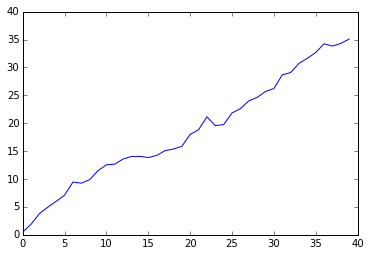

In [1]:
%matplotlib inline
from quantecon import LinearStateSpace
import numpy as np
import matplotlib.pyplot as plt

a = 0.8
b =0.5

A = np.array([[1, 1],[0, 1]])
C = np.array([[1],[0]])
G = np.array([a,b])

mu_0 = np.array([[0],[1]])

ar = LinearStateSpace(A,C,G,H = None, mu_0=mu_0)
x, y = ar.simulate(40)
y = y.flatten()

fig, ax = plt.subplots()
ax.plot(y, 'b-')
plt.show()

実際にはどのような次数のtime trendもstate-space systemで表せる．

例えば

$$
x_0 = \left[ \begin{matrix} 0 \\ 0 \\ 1 \end{matrix} \right],\ 
A = \left[ 
\begin{matrix}
1 & 1 & 0\\
0 & 1 & 1\\
0 & 0 & 1
\end{matrix}
\right],\ 
C = \left[ \begin{matrix} 0 \\ 0 \\ 0 \end{matrix} \right]
$$
とすれば
$$
A^t = \left[ 
\begin{matrix}
1 & t & t(t-1)/2\\
0 & 1 & t\\
0 & 0 & 1
\end{matrix}
\right]
$$
となるので$x'_t= (A^t x_0)' = \left[ \begin{matrix} t(t-1)/2 & t & 1 \end{matrix} \right]$
が従い，二次と一次のtime trendが表現されている．

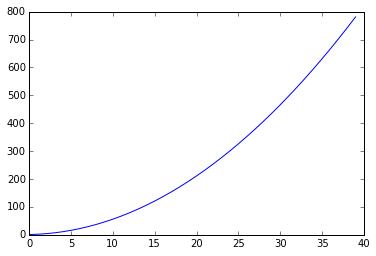

In [2]:
%matplotlib inline
from quantecon import LinearStateSpace
import numpy as np
import matplotlib.pyplot as plt

a = 0.8
b =0.5

A = np.array([[1, 1, 0], 
              [0, 1, 1], 
              [0, 0, 1]])
C = np.zeros((3,1))
G = np.ones((1, 3))

mu_0 = np.array([[0],[0],[1]])

ar = LinearStateSpace(A,C,G,H = None, mu_0=mu_0)
x, y = ar.simulate(40)
y = y.flatten()

fig, ax = plt.subplots()
ax.plot(y, 'b-')
plt.show()

### Moving Average Representations

$x_t=A x_{t-1}+C w_t$の再帰的でない表現を考える．

$$
\begin{align*}
x_t &= A x_{t-1}+C w_t\\
&= A^2 x_{t-2} + A C w_{t-1} +C w_t\\
&= A^3 x_{t-3} + A^2 C w_{t-2} + A C w_{t-1} + C w_t\\
& \hspace{30pt}\vdots\\
&=\sum^{t-1}_{j=0} A^j C w_{t-j} + A^t x_0
\end{align*}
$$
この表現をmoving average representationと呼ぶ．

例えば，$\{w_t\}$を含むtime trendを考えると，
$$
A^t=\left[ \begin{matrix} 1 & t\\ 0 & 1 \end{matrix} \right],\ 
A^jC = \left[ \begin{matrix} 1 & 0 \end{matrix} \right]'
$$
となるので，$x_t$の第一要素$x_{1t}$は
$$
x_{1t} = \sum^{t-1}_{j=0}w_{t-j} + 
\left[ \begin{matrix} 1  & t \end{matrix} \right] x_0
$$
と書ける．

一項目はmartingale differenceの累積和であり，二項目はtime trendを表すので，$x_{1t}$はmartingale with driftと呼ばれる．


## Distributions and Moments

### Unonditional Moments

以下のモデルを使って$x_t$と$y_t$の平均を表す
$$
\begin{align}
x_{t+1} &= A x_t + C w_{t+1}\\
y_t &= G x_t\\
x_0 &\sim N(\mu_0, \Sigma_0)
\end{align}
$$

$\mu_t \equiv \mathbb{E}[x_t]$として期待値の線形性を使うと$\mu_0$を所与として，
$$
\begin{align}
\mu_{t+1} &= \mathbb{E}[A x_t + C w_{t+1}]\\
&=A \mathbb{E}[x_t]+C \mathbb{E}[w_{t+1}]\\
&=A \mathbb{E}[x_t]=A \mu_t
\end{align}
$$
となる．

$x_t$の分散共分散行列$\mathbb E[(x_t-\mu_t)(x_t-\mu_t)']$を$\Sigma_t$として$x_{t+1}-\mu_{t+1}=A(x_t-\mu_t)+C w_{t+1}$を使うと$\Sigma_0$を所与として，
$$
\begin{align}
\Sigma_{t+1} &= \mathbb E[(x_{t+1}-\mu_{t+1})(x_{t+1}-\mu_{t+1})']\\
&=\mathbb E [(A(x_t-\mu_t)+C w_{t+1})(A(x_t-\mu_t)+C w_{t+1})']\\
&=\mathbb E[A(x_t-\mu_t)(x_t-\mu_t)'A'+C w_{t+1}w'_{t+1} C']\\
&=A \mathbb E[(x_t-\mu_t)(x_t-\mu_t)'] A'+ C \mathbb E[w_{t+1}w'_{t+1}]C'\\
&=A \Sigma_t A' + C C'
\end{align}
$$
と書ける．

* $\mu_t$を$x_t$のunconditional mean
* $\Sigma_t$を$x_t$のunconditional variance-covariance matrix

という

unconditionalとは言っても$\mu_0$や$\Sigma_0$には依存することに注意

### Moments of the Observations

期待値の線形性より，
$$
\mathbb E [y_t]=\mathbb E[G x_t]=G \mathbb E[x_t]=G \mu_t
$$
さらに，
$$
\begin{align}
\mathrm{Var}[y_t] &= \mathbb E[(y_t-G \mu_t)(y_t-G \mu_t)']\\
&=\mathbb E[(G x_t-G \mu_t)(G x_t-G \mu_t)']\\
&=\mathbb E[(G(x_t-\mu_t))(G(x_t-\mu_t))']\\
&=G \mathbb E[(x_t-\mu_t)(x_t-\mu_t)'] G'\\
&=G \Sigma_t G'
\end{align}
$$
が得られる


### Distributions

正規分布に対象を絞ると，平均と分散共分散行列がわかれば分布全体がわかったことになる．

よく知られているように，ある確率変数$u$が正規分布に従うとき，$u$を線形変換して得られる確率変数も正規分布に従う．
$$
u \sim N(\bar u, S)\ \text{and}\ v=a+Bu 
\Rightarrow v \sim N(a+B \bar u, BSB')
$$

**参考**：

$u \sim N(\bar u,S)$のとき，$u$の積率母関数は
$$
M_u(t)=\exp\left( \bar u' t+\frac{t' S t}{2} \right)
$$
$v=a+Bu$とすると，
$$
\begin{align}
M_v(t)&=\mathbb E\left[ e^{t'(a+Bu)} \right]\\
&=\mathbb E\left[ e^{t' Bu} \right]e^{t'a}\\
&=M_u(B't)e^{a' t}\\
&=\exp\left( \bar u' (B' t)+\frac{(B't)' S (B't)}{2} \right)e^{a't}\\
&=\exp\left( (B\bar u+a)'t+\frac{t'(B S B')t}{2} \right)
\end{align}
$$
これは$N(B\bar u+a, B S B')$の積率母関数なので$v$は$N(B\bar u+a, B S B')$に従う．

今$x_0$は正規分布に従い，$x_t$と$y_t$は$x_0$の線形変換により作られるのでこれらも正規分布に従う．



$x_t$と$y_t$の平均と分散共分散行列は既に求めたので，
$$
\begin{align}
x_t &\sim N(\mu_t, \Sigma_t)\\
y_t &\sim N(G \mu_t, G \Sigma_t G')
\end{align}
$$
を得る．


### Ensemble Interpretations

得られた$x_t$と$y_t$の分布の解釈：

分布が表す確率は繰り返しその分布に従って値を選んだときの相対的な頻度に対応

#### 例

$$
A = \left[ 
\begin{matrix}
\phi_1 & \phi_2 & \phi_3 & \phi_4\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0
\end{matrix}
\right],\ 
C = \left[ \begin{matrix} \sigma \\ 0 \\ 0 \\ 0  \end{matrix} \right],\ 
G = \left[ \begin{matrix} 1 & 0 & 0 & 0 \end{matrix} \right]
$$
($\phi_1 = 0.5$, $\phi_2 = -0.2$, $\phi_3 = 0$, $\phi_4=0.5$, $\sigma = 0.1$) を，
$
x_0 = \left[ \begin{matrix} 1 & 1 & 1 & 1 \end{matrix} \right]' 
$
としてプロット

sample size: 20


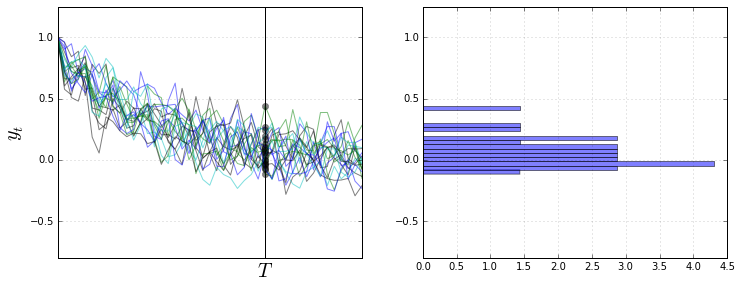

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from quantecon import LinearStateSpace
import random

phi_1, phi_2, phi_3, phi_4 = 0.5, -0.2, 0, 0.5
sigma = 0.1

A = np.array([[phi_1, phi_2, phi_3, phi_4],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
C = np.array([[sigma], [0], [0], [0]])
G = np.array([1, 0, 0, 0])

T = 30
sample_size = 20
ar = LinearStateSpace(A, C, G, mu_0 = np.ones(4))


ymin, ymax = -0.8, 1.25

fig, axes = plt.subplots(1, 2, figsize=(12,4.5))

for ax in axes:
    ax.grid(alpha=0.4)
    
ax = axes[0]

ax.set_ylim(ymin, ymax)
ax.set_ylabel(r'$y_t$', fontsize = 20)
ax.vlines((T,), -1.5, 1.5)

ax.set_xticks((T,))
ax.set_xticklabels((r'$T$',), fontsize = 20)

sample = []
for i in range(sample_size):
    rcolor = random.choice(('c', 'g', 'b', 'k'))
    x, y = ar.simulate(ts_length=T+15)
    y = y.flatten()
    ax.plot(y, color=rcolor, lw=1, alpha=0.5)
    ax.plot((T,), (y[T],), 'ko', alpha=0.5)
    sample.append(y[T])
    
y = y.flatten()
axes[1].set_ylim(ymin, ymax)
axes[1].hist(sample, bins=16, normed=True, orientation='horizontal', alpha=0.5)

print('sample size:', sample_size)
plt.show()




sample size: 100


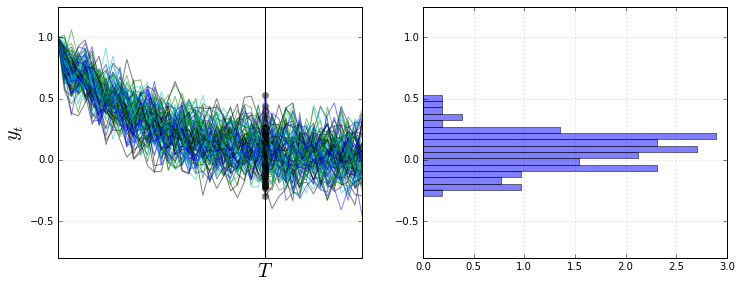

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from quantecon import LinearStateSpace
import random

phi_1, phi_2, phi_3, phi_4 = 0.5, -0.2, 0, 0.5
sigma = 0.1

A = np.array([[phi_1, phi_2, phi_3, phi_4],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
C = np.array([[sigma], [0], [0], [0]])
G = np.array([1, 0, 0, 0])

T = 30
sample_size = 100
ar = LinearStateSpace(A, C, G, mu_0 = np.ones(4))


ymin, ymax = -0.8, 1.25

fig, axes = plt.subplots(1, 2, figsize=(12,4.5))

for ax in axes:
    ax.grid(alpha=0.4)
    
ax = axes[0]

ax.set_ylim(ymin, ymax)
ax.set_ylabel(r'$y_t$', fontsize = 20)
ax.vlines((T,), -1.5, 1.5)

ax.set_xticks((T,))
ax.set_xticklabels((r'$T$',), fontsize = 20)

sample = []
for i in range(sample_size):
    rcolor = random.choice(('c', 'g', 'b', 'k'))
    x, y = ar.simulate(ts_length=T+15)
    y = y.flatten()
    ax.plot(y, color=rcolor, lw=1, alpha=0.5)
    ax.plot((T,), (y[T],), 'ko', alpha=0.5)
    sample.append(y[T])
    
y = y.flatten()
axes[1].set_ylim(ymin, ymax)
axes[1].hist(sample, bins=16, normed=True, orientation='horizontal', alpha=0.5)

print('sample size:', sample_size)
plt.show()


sample size: 75000


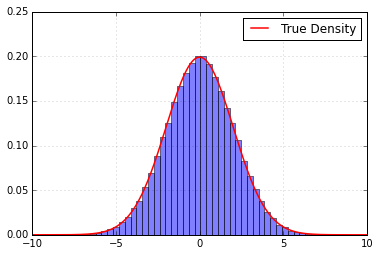

In [19]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from quantecon import LinearStateSpace
import random
from scipy.stats import norm

phi_1, phi_2, phi_3, phi_4 = 0.5, -0.2, 0, 0.5
sigma = 0.1

A = np.array([[phi_1, phi_2, phi_3, phi_4],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
C = np.array([[sigma], [0], [0], [0]])
G = np.array([1, 0, 0, 0])

mu_0 = np.ones(4)

T = 30
sample_size = 75000
ar = LinearStateSpace(A, C, G, mu_0)


ymin, ymax = -0.8, 1.25

fig, ax = plt.subplots()

ax.grid(alpha=0.4)

sample = ar.replicate(T, sample_size)[1]

moment = ar.moment_sequence()
mu_seq = np.empty(T)
Sigma_seq = np.empty(T)
for i in range(T):
    temp = next(moment) # 欲しいのは最終期のmomentだが，``moment''はgeneratorなので順番に取り出す
    mu_seq[i] = float(temp[1]) # observationの平均
    Sigma_seq[i] = float(temp[3]) # observationの分散
    
mu_T = mu_seq[-1]
Sigma_T = Sigma_seq[-1]

sample = sample.flatten()
ax.hist(sample, bins=50, normed=True, alpha=0.5)
lin = np.linspace(-10, 10, 300)
plt.plot(lin, norm(mu_T, np.sqrt(Sigma_T)).pdf(lin), 'r-', linewidth=1.5, label="True Density") #normの二つ目の引数は標準偏差
plt.legend()

print('sample size:', sample_size)
plt.show()


### Ensemble means

前節のシミュレーションでは，

1. 十分多くの$I$個のサンプルを生成する
2. 各$i=1,\dots,I$について$y^i_T$を記録
3. $(y^1_T, y^2_T, \dots, y^I_T)$のヒストグラムを描く

という手順で$y_T$の分布を近似した．

*ensemble (cross-sectional) average* :  各サンプルの$T$期の値を取りだして平均をとったもの

ensemble (cross-sectional) average
$$
\bar y_T = \frac{1}{I}\sum^I_{i=1}y^i_T
$$
は$\mathbb E[y_T]=G \mu_T$の近似になる．



sample size: 20


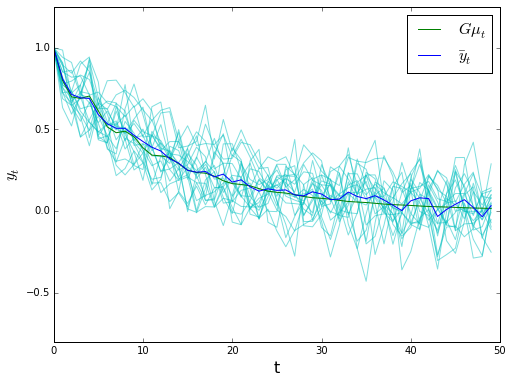

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from quantecon import LinearStateSpace
import random

phi_1, phi_2, phi_3, phi_4 = 0.5, -0.2, 0, 0.5
sigma = 0.1

A = np.array([[phi_1, phi_2, phi_3, phi_4],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
C = np.array([[sigma], [0], [0], [0]])
G = np.array([1, 0, 0, 0])

T = 50
sample_size = 20
ar = LinearStateSpace(A, C, G, mu_0 = np.ones(4))

print('sample size:', sample_size)

ymin, ymax = -0.8, 1.25

fig, ax = plt.subplots(figsize=(8,6))
  
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r't', fontsize = 16)
ax.set_ylabel(r'$y_t$', fontsize = 16)

moment = ar.moment_sequence()
mu_seq = np.empty(T)
for i in range(T):
    temp = next(moment)
    mu_seq[i] = temp[1].flatten()


samples = []
for i in range(sample_size):
    x, y = ar.simulate(ts_length=T)
    y = y.flatten()
    samples.append(y)
    ax.plot(y, color='c', lw=1, alpha=0.5)

mean_seq = []

for t in range(T):
    mean = sum(sample[t] for sample in samples) / sample_size
    mean_seq.append(mean)
    

ax.plot(mu_seq, 'g-', label=r'$G \mu_t$')
ax.plot(mean_seq, 'b-', label=r'$\bar y_t$')
ax.legend(fontsize=16)
#    sample.append(y[T])

   
plt.show()




$x$についても同様に
$$
\frac{1}{I}\sum^I_{i=1}x^i_t \to \mu_t\ \text{as $I \to \infty$}
$$
が成り立つ．

sample size: 20


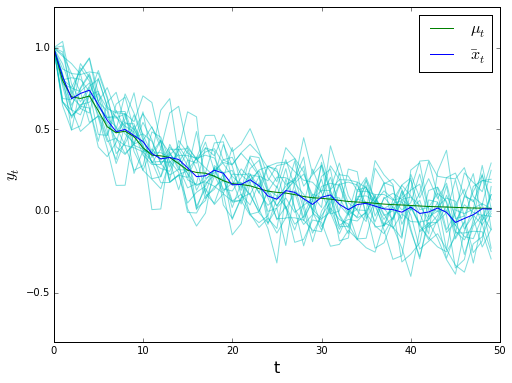

In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from quantecon import LinearStateSpace
import random

phi_1, phi_2, phi_3, phi_4 = 0.5, -0.2, 0, 0.5
sigma = 0.1

A = np.array([[phi_1, phi_2, phi_3, phi_4],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
C = np.array([[sigma], [0], [0], [0]])
G = np.array([1, 0, 0, 0])

T = 50
sample_size = 20
ar = LinearStateSpace(A, C, G, mu_0 = np.ones(4))


ymin, ymax = -0.8, 1.25

fig, ax = plt.subplots(figsize=(8,6))
  
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r't', fontsize = 16)
ax.set_ylabel(r'$y_t$', fontsize = 16)

moment = ar.moment_sequence()
mu_seq = np.empty(T)
for i in range(T):
    temp = next(moment)
    mu_seq[i] = temp[0][0]


samples = []
for i in range(sample_size):
    x, y = ar.simulate(ts_length=T)
    x = x[0]
    samples.append(x)
    ax.plot(x, color='c', lw=1, alpha=0.5)

mean_seq = []

for t in range(T):
    mean = sum(sample[t] for sample in samples) / sample_size
    mean_seq.append(mean)
    

ax.plot(mu_seq, 'g-', label=r'$\mu_t$')
ax.plot(mean_seq, 'b-', label=r'$\bar x_t$')
ax.legend(fontsize=16)
#    sample.append(y[T])

print('sample size:', sample_size)   
plt.show()




### Joint Distributions

ここまでで各時点$t$の$x_t$と$y_t$の分布が得られた．

しかし，これだけでは

* 全ての$t$について$x_t \geq 0$となる確率は？
* 列$\{y_t\}$がある範囲に収まる確率は？

のような疑問には答えられない．

この答えを得るにはjoint distributionを考える必要がある．

一般に確率変数$a$と$b$のjoint distributionには次のような関係がある．
$$
p(a,b)=p(b \mid a)p(a)
$$
これを使うと，$p(x_0, x_1)=p(x_1 \mid x_0)p(x_0)$が得られる．
マルコフ性より$p(x_t \mid x_{t-1}, \dots x_0)=p(x_t \mid x_{t-1})$なので，
$$
\begin{align}
p(x_0,x_1,\dots,x_T) &= p(x_T \mid x_{T-1},\dots,x_0)p(x_0,x_1,\dots,x_{T-1})\\
&= p(x_T \mid x_{T-1})p(x_0,\dots,x_{T-1})\\
&= p(x_T \mid x_{T-1})p(x_{T-1} \mid x_{T-2})\dots p(x_1 \mid x_0) p(x_0)\\
&= p(x_0)\prod^{T-1}_{t=0} p(x_{t+1} \mid x_t)
\end{align}
$$
ここで，$p(x_0)$は所与の$N(\mu_0, \Sigma_0)$である．

また，$x_t$が確定したとすると，
$$
\begin{align}
\mu_{t+1 \mid t} &=\mathbb E[A x_t + C w_{t+1} \mid x_t]
=A x_t+C \mathbb E[w_{t+1} \mid x_t]=A x_t, \\
\Sigma_{t+1 \mid t}&=\mathbb E[(A x_t+ C w_{t+1}-\mu_{t+1})(A x_t+ C w_{t+1}-\mu_{t+1})' \mid x_t]\\
&=\mathbb E[(A x_t+C w_{t+1}-A x_t)(A x_t+C w_{t+1}-A x_t)' \mid x_t]\\
&=\mathbb E[C w_{t+1} w'_{t+1}C' \mid x_t]=C\Sigma[w_{t+1}]C'=CC'
\end{align}
$$
となり，$x_{t+1}$は正規分布に従うので
$$
p(x_{t+1} \mid x_t)=N(A x_t, CC')
$$
を得る．

### Autocovariance functions

autocovariance function:
$$
\Sigma_{t+j, t}\equiv \mathbb E[(x_{t+j}-\mu_{t+j})(x_t-\mu_t)']
$$
ここで，
$$
\begin{align}
x_{t+j}&=A x_{t+j-1}+C w_{t+j}=A(A x_{t+j-2}+C w_{t+j-1})+C w_{t+j}\\
&=\dots=A^j x_{t}+\sum^{j-1}_{k=0}A^kC w_{t+j-k}\\
\mu_{t+j}&=A \mu_{t+j-1}=A^2 \mu_{t+j-2}=\dots =A^j \mu_t
\end{align}
$$
なので，
$$
\begin{align}
\Sigma_{t+j, t}&=\mathbb E\left[\left( A^j(x_t-\mu_t) +\sum^{j-1}_{k=0}A^kC w_{t+j-k} \right)(x_t-\mu_t)'\right]\\
&=\mathbb E[A^j(x_t-\mu_t)(x_t-\mu_t)']+\mathbb E \left[ \sum^{j-1}_{k=0}A^kC w_{t+j-k} (x_t-\mu_t)' \right]=A^j \Sigma_t
\end{align}
$$
と書け，任意の二時点間の共分散行列が得られる．

## Stationarity and Ergodicity

StationarityとErgodicityが満たされているとlinear state space modelの分析がしやすくなる．

### Visualizing Stability

ensemble momentsを考えるときに使った時系列モデルを再び取り上げる．

sample size: 80


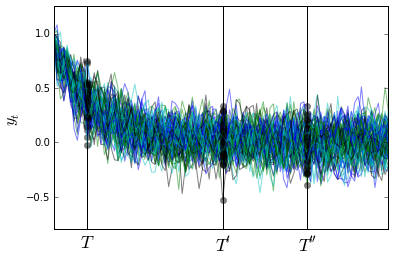

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from quantecon import LinearStateSpace
import random

phi_1, phi_2, phi_3, phi_4 = 0.5, -0.2, 0, 0.5
sigma = 0.1

A = np.array([[phi_1, phi_2, phi_3, phi_4],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
C = np.array([[sigma], [0], [0], [0]])
G = np.array([1, 0, 0, 0])

T = 10
T2 = 50
T3 = 75
sample_size = 80
ar = LinearStateSpace(A, C, G, mu_0 = np.ones(4))


ymin, ymax = -0.8, 1.25

fig, ax = plt.subplots()

ax.set_ylim(ymin, ymax)
ax.set_ylabel(r'$y_t$', fontsize = 16)
ax.vlines((T,T2,T3), -1.5, 1.5)

ax.set_xticks((T,T2, T3))
ax.set_xticklabels((r'$T$',r"$T'$",r"$T''$"), fontsize=18)

sample = []
for i in range(sample_size):
    rcolor = random.choice(('c', 'g', 'b', 'k'))
    x, y = ar.simulate(ts_length=T3+25)
    y = y.flatten()
    ax.plot(y, color=rcolor, lw=1, alpha=0.5)
    ax.plot((T, T2, T3), (y[T], y[T2],  y[T3]), 'ko', alpha=0.5)
    sample.append(y[T])

print('sample size:', sample_size)
plt.show()


早い時点の$T$に比べて，ある程度時間の経った$T'$や$T''$ではほぼ同じような値の$y_t$が実現している．

十分先の時点では実現値の分布が一定になり，これをstationary distributionという．

### Stationary Distributions

分布$\psi_\infty$が$x_t$に対しstationaryである：
$$
x_t \sim \psi_\infty\ \text{and}\ x_{t+1}=A x_t + C w_{t+1} \Rightarrow x_{t+1} \sim \psi_\infty
$$
この定義は以下のように言い換えられる
$$
\psi_\infty = N(\mu_\infty, \Sigma_\infty)
$$
ただし$\mu_\infty$と$\Sigma_\infty$はそれぞれ$\mu_{t+1}=A \mu_t$と$\Sigma_{t+1}=A \Sigma_t A'+CC'$の不動点

### Covariance Stationary processes

先ほどのシミュレーションを$x_0$を定常分布に従い選んで行う．
つまり，$x_0 \sim N(\mu_\infty, \Sigma_\infty)$．

sample size: 80


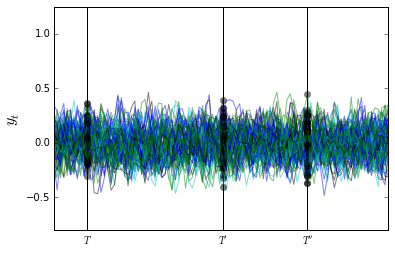

In [27]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from quantecon import LinearStateSpace
import random

phi_1, phi_2, phi_3, phi_4 = 0.5, -0.2, 0, 0.5
sigma = 0.1

A = np.array([[phi_1, phi_2, phi_3, phi_4],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
C = np.array([[sigma], [0], [0], [0]])
G = np.array([1, 0, 0, 0])

T = 10
T2 = 50
T3 = 75
sample_size = 80
ar = LinearStateSpace(A, C, G, mu_0 = np.ones(4))

# mu_0とSigma_0を定常分布の平均と分散共分散行列で置き換える
ar.mu_0 = ar.stationary_distributions()[0]
ar.Sigma_0 = ar.stationary_distributions()[2]


print('sample size:', sample_size)

ymin, ymax = -0.8, 1.25

fig, ax = plt.subplots()

ax.set_ylim(ymin, ymax)
ax.set_ylabel(r'$y_t$', fontsize = 16)
ax.vlines((T,T2,T3), -1.5, 1.5)

ax.set_xticks((T,T2, T3))
ax.set_xticklabels((r'$T$',r"$T'$",r"$T''$"))

sample = []
for i in range(sample_size):
    rcolor = random.choice(('c', 'g', 'b', 'k'))
    x, y = ar.simulate(ts_length=T3+25)
    y = y.flatten()
    ax.plot(y, color=rcolor, lw=1, alpha=0.5)
    ax.plot((T, T2, T3), (y[T], y[T2],  y[T3]), 'ko', alpha=0.5)
    sample.append(y[T])
    
plt.show()


$\mu_\infty$と$\Sigma_\infty$は不動点なので，
$$
\mu_t = \mu_\infty\ \text{and}\ \Sigma_t = \Sigma_\infty\ \forall t 
$$
すると，autocovariance functionについて$\Sigma_{t+j,t}=A^j \Sigma_\infty$が成り立ち，この値は$t$に依存しないことがわかる．

これを踏まえてcovariance stationarityを定義すると，

$\{x_t\}$がcovariance stationaryであるとは，
* $\mu_t$と$\Sigma_t$が$t$について定数である
* $\Sigma_{t+j,t}$が$t$に依存しない

ことである．

今考えているLinear State Space Modelでは$\mu_0$, $\Sigma_0$, $A$, $C$から得られる$\mu_t$, $\Sigma_t$, $\Sigma_{t+j,t}$が$t$に依存しないとき$\{x_t\}$はcovariance stationaryになる．

## Conditions for Stationarity

### The globally stable case

差分方程式$\mu_{t+1}=A \mu_t$について考える．$A$の全ての固有値の絶対値が$1$より厳密に小さい時この差分方程式は一意の不動点$\mu_\infty=0$を持つ．シミュレーションでこの条件を調べるときは，
`np.absolute(np.linalg.eigvals(A)) < 1).all()`が`True`になることを確認すればよい．



さらにこのとき$\Sigma_{t+1}=A \Sigma_t A'+C C'$も不動点を持ち，初期値$\mu_0$, $\Sigma_0$によらず
$$
\mu_t \to \mu_\infty = 0\ \text{and}\ \Sigma_t \to \Sigma_\infty\ \text{as}\ t \to \infty
$$
が成り立つ．
このように初期時点に依存せず値が不動点に収束するとき，globally stableであるという．

global stabilityはここで使う条件として強すぎる

例えばsecond order difference equationの例を考える．

$$
\begin{align}
&x_t = \left[
\begin{matrix}
1 \\ y_t \\ y_{t-1}
\end{matrix}
\right]
&A =\left[
\begin{matrix}
1 & 0 & 0 \\ \phi_0 & \phi_1 & \phi_2 \\ 0 & 1 & 0
\end{matrix}
\right]\\
&C = \left[
\begin{matrix}
0 \\ 0 \\ 0
\end{matrix}
\right]
&G=\left[
\begin{matrix}
0 & 1 & 0
\end{matrix}
\right]
\end{align}
$$

の場合を考えると，$x_t = \left[ \begin{matrix} 1 & y_t & y_{t-1} \end{matrix} \right]'$であり定数を含むので$\mu_t \to 0$にはならない．

### Processes with a constant stable compnent

$$
A = \left[ 
\begin{matrix}
A_1 & a\\
0 & 1
\end{matrix}
\right],\ 
C = \left[ 
\begin{matrix}
C_1 \\ 0
\end{matrix}
\right],\ 
x_t=\left[
\begin{matrix}
x'_{1t} & 1
\end{matrix}
\right]'
$$
を考える．ただし，
* $A_1$は$(n-1) \times (n-1)$行列
* $a$は$(n-1) \times 1$ベクトル
* $x_{1t}$は$(n-1) \times 1$ベクトル

である．$x_{t+1}=A x_t + C w_{t+1}$について第一成分に注目すると，
$$
\begin{align}
x_{1,t+1}&=\left[ \begin{matrix} A_1 & a \end{matrix} \right]
\left[\begin{matrix} x_{1t} & 1 \end{matrix} \right]'
+C_1 w_{t+1}\\
&=A_1 x_{1t}+a+C_1 w_{t+1}
\end{align}
$$
となる．$\mu_{1t}=\mathbb E[x_{1t}]$とすると以下を得る．
$$
\begin{align}
\mathbb E[x_{1,t+1}] &= \mathbb E[A_1 x_{1t} + a + C_1 w_{t+1}]\\
&=A_1 \mathbb E[x_{1t}] + a +C_1 \mathbb E[w_{t+1}]\\
\Rightarrow \mu_{1,t+1} &= A_1 \mu_{1,t} + a
\end{align}
$$

ここで$A_1$の全ての固有値の絶対値が1より厳密に小さいとすると，この式に定常解$\mu_{1, \infty}$が一意に存在して，
$$
\begin{align}
&\mu_{1, \infty}=A_1 \mu_{1, \infty}+a\\
\iff &\mu_{1,\infty} = (I-A_1)^{-1}a
\end{align}
$$
を満たす．したがって$\mu_t$の定常値は$\mu_{\infty}=\left[\begin{matrix} 
\mu'_{1 \infty} & 1\end{matrix}\right]'$となる．

$\Sigma_t$と$\Sigma_{t+j,t}$について，以下が成り立つ．
$$
\begin{align}
\Sigma_\infty &= A \Sigma_\infty A' + C C'\\
\Sigma_{t+j,t} & = A^j \Sigma_\infty
\end{align}
$$
まとめると，
* $x_0 \sim N(\mu_\infty, \Sigma_\infty)$
* $A_1$の全ての固有値の絶対値が1未満

のとき，$\{x_t\}$はcovariance stationarityを満たす．


### Ergodicity

covariance stationary processを考える．このときensemble meanは$I \to \infty$にしたがって$\mu_\infty$に収束する

### Averages over time

サンプルサイズを限りなく大きくすることで得られるensemble averagesは理論的に面白いが，現実に観察できるデータは一種類だけ．

そこでここでは一つのデータを選び，時間に関する平均を考える．すなわち，
$$
\bar x =\frac{1}{T}\sum^T_{t=1}x_t\ \text{and}\ \bar y=\frac{1}{T}\sum^T_{t=1} y_t
$$
この値は$T \to \infty$に従ってstate-space representationで解釈可能な値に収束するか？→モデルのエルゴード性次第

**エルゴード性**：時系列の平均とensemble meanが一致するという性質

つまり，
* $\frac{1}{T} \sum^T_{t=0}x_t \to \mu_\infty$
* $\frac{1}{T} \sum^T_{t=0}(x_t - \bar x_T)(x_t - \bar x_T)' \to \Sigma_\infty$
* $\frac{1}{T} \sum^T_{t=0}(x_{t+j}-\bar x_T)(x_t-\bar x_T)' \to A^j \Sigma_\infty$

今考えているlinear Gaussianの設定ではcovariance stationarityはエルゴード性の十分条件になっている．

## Noisy Observations

観察される$y_t$が真の値からの誤差を含むモデルを考える．このモデルは状態を不完全にしか観察できない状況を表す．

* $v_t \sim N(0,I)$：iidの$l \times 1$ベクトル
* $H$：$k \times l$行列

を導入し，linear state-space systemを以下のように拡張する．
$$
\begin{align}
x_{t+1} &= A x_t + C w_{t+1}\\
y_t &= G x_t + H v_t\\
x_0 &\sim N(\mu_0, \Sigma_0)
\end{align}
$$
ただし$\{v_t\}$は$\{w_t\}$とは独立とする．

このとき$y_t$のモーメントは，
$$
\mathbb E[y_t] = \mathbb E[G x_t+H v_t]=G \mathbb E[x_t]+H \mathbb E[v_t]
= G \mu_t
$$
分散共分散行列は，
$$
\begin{align}
\textrm{Var}[y_t] &= \textrm{Var}[G x_t+H v_t]
=\mathbb E[(G x_t + H v_t)(G x_t + H v_t)']\\
&=\mathbb E[G x_t x_t' G' + G x_t v'_t H' + H v_t x'_t G' + H v_t v'_t H']\\
&=G \mathbb E[x_t x'_t] G'+ H \mathbb E[v_t v'_t] H'=G \Sigma_t G' + H H'
\end{align}
$$
となるので$y_t$の分布は
$$
y_t \sim N(G \mu_t, G \Sigma_t G' + H H')
$$

## Prediction

linear state space systemにおける予測を考える．

### Forecasting Formulas - Conditional Means

変数の値の予測をする自然な方法は条件付分布を使う方法である．

例えば，$t$時点において与えられた情報を元にした$x_{t+1}$の最適な予想は，
$$
\begin{align}
\mathbb E_t[x_{t+1}] &\equiv \mathbb E[x_{t+1} \mid x_t, x_{t-1},\dots, x_0]\\
&= \mathbb E[A x_t + C w_{t+1} \mid x_t, x_{t-1}, \dots, x_0]\\
&= A \mathbb E[x_t \mid x_t, x_{t-1},\dots, x_0] 
+C \mathbb E[w_{t+1} \mid x_t, x_{t-1}, \dots, x_0]
=A x_t
\end{align}
$$
この導出には$x_{t-1}$以前の情報を使っていないので$\mathbb E_t[x_{t+1}]=\mathbb E[x_{t+1} \mid x_t]$が成立：$\{x_t\}$はマルコフ性を満たす．

一時点先で真の値と予測の誤差を求めると，
$$
x_{t+1} - \mathbb E_t[x_{t+1}] = A x_t + C w_{t+1} - A x_t = C w_{t+1}
$$
予測誤差の共分散行列は，
$$
\begin{align}
\mathbb E[(x_{t+1} - \mathbb E_t[x_{t+1}])(x_{t+1}-\mathbb E_t[x_{t+1}])']=\mathbb E[C w_{t+1} w'_{t+1} C']=C C'
\end{align}
$$

より一般に，$j$時点先の予測を行いたい．まず，
$$
\begin{align}
x_{t+1} &= A x_t + C w_{t+1}\\
x_{t+2} &= A x_{t+1} + C w_{t+2}=A^2 x_t + A C w_{t+1} + C w_{t+2}\\
x_{t+3} &= A x_{t+2} + C w_{t+3}=A^3 x_t + A^2 C w_{t+1} + A C w_{t+2} + C w_{t+3}\\
&\vdots\\
x_{t+j} &= A^j x_{t} + A^{j-1} C w_{t+1} + A^{j-2} C w_{t+2} + \dots + A^0 C w_{t+j}
\end{align}
$$
となるが，$\{w_t\}$はiidなので各時点の値は過去の情報には依存せず，$\mathbb E_t[w_{t+k}]=\mathbb E[w_{t+k}]=0$が成り立つ．よって，
$$
\mathbb E_t[x_{t+j}]= \mathbb E_t[A^j x_{t} + A^{j-1} C w_{t+1} + A^{j-2} C w_{t+2} + \dots + A^0 C w_{t+j}] = A^j \mathbb E_t[x_t]=A^j x_t
$$
となる．これを使うと，
$$
\mathbb E_t[y_{t+j}]= \mathbb E_t[G x_{t+j} + H v_{t+j}]
=G \mathbb E_t[x_{t+j}] + H \mathbb E_t[v_{t+j}]=G A^j x_t
$$
が従う．

### Covariance of Prediction Errors

$j$時点先の誤差
$$
x_{t+j}- \mathbb E_t[x_{t+j}] = \sum^{j-1}_{s=0}A^s C w_{t-s+j}
$$
の分散共分散行列を考える．
分散が小さいほど精度の良い予測になっている．

$V_j \equiv \mathbb E_t[(x_{t+j}- \mathbb E_t[x_{t+j}])(x_{t+j}- \mathbb E_t[x_{t+j}])']$と定義すると，
$$
\begin{align}
V_j&=\mathbb E_t\left[ \left(\sum^{j-1}_{s=0}A^s C w_{t-s+j}\right) \left(\sum^{j-1}_{s=0}A^s C w_{t-s+j} \right)'\right]
=\sum^{j-1}_{k=0}A^k C \mathbb E[w_{t-s+j}w'_{t-s+j}] C' {A^k}'\\
&=\sum^{j-1}_{k=0}A^k C C' {A^k}'
\end{align}
$$
さらに$V_j$を再帰的に表すと，
$$
\begin{align}
V_1 &= CC'\\
V_2 &= CC' + ACC'A'\\
V_3 &= CC' + ACC'A' + A^2 CC' {A^2}'=CC'+A(CC'+ACC'A')A'\\
&=CC' + AV_2A'\\
&\hspace{15pt}\vdots\\
V_j &= CC' + AV_{j-1}A',\ j \geq 2
\end{align}
$$
となる．ある条件の下では$V_j$は$V_\infty = CC'+AV_\infty A'$に収束する．
一つの十分条件は$A$の固有値の絶対値が1より小さいこと．

より弱い十分条件は，$A$の固有値の絶対値が1以上でかつ$C$の要素に$0$を含むことである．

### Forecasts of Geometric Sums

$\{x_t\}$や$\{y_t\}$のgeometric sumの期待値を求めたい．これは例えば株式市場のモデルでの配当の総和などに対応する．

### Formulas

$A$の全ての固有値の絶対値が$1/\beta$未満であるとする．

$A$の$i$番目の固有値を$\lambda_i$とすると$\beta A$のスペクトル半径$\rho (\beta A)$について
$$
\rho (\beta A) \equiv \max_i \| \beta \lambda_i \|=\beta \max_i \| \lambda_i \|<\beta \cdot \frac{1}{\beta}=1
$$
が成り立つ．するとGelfandの公式より
$$
\rho(\beta A)=\lim_{k \to \infty} \| (\beta A)^k \|^{1/k} <1
$$
すなわちある$\bar k$が存在して，任意の$k \geq \bar k$について$\| (\beta A)^k \|^{1/k}<1 \Rightarrow \|(\beta A)^k\|<1$となる．
よってNeumannの定理より
$$
I+\beta A + \beta^2 A^2 + \dots =\sum^\infty_{k=0}(\beta A)^k=(I-\beta A)^{-1}
$$
が成り立つ

これを使うと，
$$
\begin{align}
\mathbb E_t \left[ \sum^\infty_{j=0}\beta^j x_{t+j} \right]
&=[I+\beta A + \beta^2 A^2 + \dots]x_t=[I-\beta A]^{-1}x_t\\
\mathbb E_t \left[ \sum^\infty_{j=0}\beta^j y_{t+j} \right]
&=G[I+\beta A + \beta^2 A^2 + \dots]x_t=G[I-\beta A]^{-1}x_t
\end{align}
$$
が得られる．

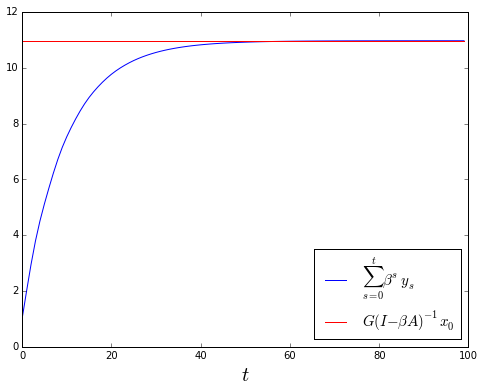

In [4]:
%matplotlib inline

from quantecon import LinearStateSpace
import numpy as np
import matplotlib.pyplot as plt

T = 100
phi0, phi1, phi2 = 1.1, .8, -0.8
y0, yminus1 = 1, 1

phi0, phi1, phi2 = 1.1, 0.8, -0.8

A = np.array([[1, 0, 0],
              [phi0, phi1, phi2],
              [0, 1, 0]])
C = np.array([[0], [0], [0]])
G = np.array([0, 1, 0])
mu_0 = np.array([1,1,1])

beta = 0.9

ar = LinearStateSpace(A, C, G, H=None, mu_0=mu_0, Sigma_0=None)
x, y = ar.simulate(T)

y = y.flatten()

z = np.array([beta**i * y[i] for i in range(len(y))])

z_sum = z.cumsum()

geo_sum = [ar.geometric_sums(beta, mu_0)[1] for t in range(T)]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(z_sum, 'b-', label=r'$\sum^t_{s=0} \beta^s y_s$')
ax.plot(geo_sum, 'r-', label=r'$G(I-\beta A)^{-1}x_0$')
ax.set_xlabel(r'$t$', fontsize=20)
plt.legend(loc='lower right',fontsize=15)
plt.show()